# Metis Data Science Bootcamp
## San Francisco, Winter 2020
### Project 4: Election Reporting Sentiment Analysis

### Topic Modeling - Time Series

One of the goals of this project is to evaluation topic importance over time.  This notebook breaks the article database into sections by week and examines the changes in feature importance over time.

In [44]:
import sys
import re
import os.path
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from os import path

from pymongo import MongoClient

In [45]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import re
import string

from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

Open an connection to Mongo and get cursors for the news collections

In [3]:
db_client = MongoClient()
db_news = db_client['news_search']
db_news_col = db_news['search_result']

In [4]:
db_news_content = db_news['news_content']
cursor = db_news_content.find({}, {'_id':0, 'name': 1, 'text': 1, 'url' : 1, 'base_url' : 1, 'pub_date': 1})

In [5]:
db_news_content = db_news['news_content']



Define some utility functions that will come in handy later

In [6]:
def get_top_words(topic, feature_names, n_top_words):
    word_list = []
    word_list = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    
    return word_list

def print_top_words(model, feature_names, n_top_words):
    word_list = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ' '.join(get_top_words(topic, feature_names, n_top_words))
        print(message)
    print()

## Build a Pipeline

In [7]:
def build_corpus(cur, field1, field2) :
    articles = list(cur)

    X_what = []
    y = []
    for article in articles :
        X_what.append(article[field2])
        y.append(article[field1])
    return X_what, y

In [8]:
# build our corpus
corpus = []
cursor = db_news_content.find({}, {'_id':1, 'text': 1, 'short_text' : 1, 'prop_nouns' : 1})
for article in list(cursor) :
    corpus.append(article['short_text'])


In [9]:
vectorizer = CountVectorizer(stop_words='english', max_df=1.5, max_features=80, ngram_range=(1,2))
lda_model = LatentDirichletAllocation(n_components=8,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

#pipe = Pipeline([('CV', vectorizer), ('LDA', lda_model)])

In [10]:
#X_lda_what = pipe.fit_transform(X_what)

In [11]:
def block_fit_transform(vect,model, corpus, data=None) :
    vect_out = vect.fit(corpus)
    
    if data is not None :
        dat_xform = vect_out.transform(data)
    else :
        dat_xform = vect_out.transform(corpus)
        
    model_out = model.fit_transform(dat_xform)
    return dat_xform, vect_out, model_out

## Run the models for different slices of time

Prep some values for later visualization

In [12]:
# Find the range for the publication dates
cursor = db_news_content.find({}, {'_id':1, 'dt_pub_date' : 1})
date_list = [x['dt_pub_date'] for x in list(cursor)]
date_list.sort()
date_list = date_list[1:]
min(date_list), max(date_list)

(datetime.datetime(2019, 11, 12, 0, 0), datetime.datetime(2020, 2, 25, 0, 0))

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([1.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 2.300e+01,
        2.740e+02, 8.780e+02, 1.069e+03, 1.538e+03]),
 array([737375. , 737385.5, 737396. , 737406.5, 737417. , 737427.5,
        737438. , 737448.5, 737459. , 737469.5, 737480. ]),
 <a list of 10 Patch objects>)

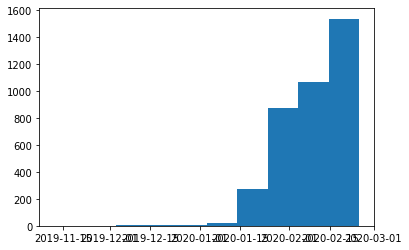

In [13]:
plt.hist(date_list)

In [14]:
start_date = dt.datetime(2020, 1, 12)
end_date = max(date_list)
 
window_size = dt.timedelta(days=7)

next_date = start_date

date_windows = [start_date]

while next_date < end_date :
    next_date = next_date + window_size
    date_windows.append(next_date)

In [15]:
date_windows

[datetime.datetime(2020, 1, 12, 0, 0),
 datetime.datetime(2020, 1, 19, 0, 0),
 datetime.datetime(2020, 1, 26, 0, 0),
 datetime.datetime(2020, 2, 2, 0, 0),
 datetime.datetime(2020, 2, 9, 0, 0),
 datetime.datetime(2020, 2, 16, 0, 0),
 datetime.datetime(2020, 2, 23, 0, 0),
 datetime.datetime(2020, 3, 1, 0, 0)]

In [16]:
def get_window_corpus(db, text_field, start_date, end_date):
    cursor = db.find({ 'dt_pub_date': {
        '$gte' : start_date,
        '$lt' : end_date}}, {'_id': 1, text_field: 1})
    
    # Build a corpus from those articles
    return build_corpus(cursor, '_id', text_field)

In [17]:
def get_window_vals(db, text_field, start_date, end_date):
    val_list = []
    
    cursor = db.find({ 'dt_pub_date': {
        '$gte' : start_date,
        '$lt' : end_date}}, {'_id': 1, text_field: 1})
    
    for article in list(cursor) :
        val_list.append(article[text_field])    
    
    # Build a corpus from those articles
    return val_list

In [18]:
def build_window_model(model, vect, db, field, start_date, end_date):
    window_corpus, window_ids = get_window_corpus(db, field, start_date, end_date)
    
    # Train and fit the model
    return block_fit_transform(vect, model, window_corpus)

In [19]:
window_word_list = []
window_component_list = []
n_words = 5

window_data = {}

# For each date window
for i in range(len(date_windows)-1) :
    top_word_list = []
    top_component_list = []
    '''
    # Get the articles in that date range
    corpus, id_list = get_window_corpus(db_news_content, 'short_text', date_windows[i], date_windows[i+1])

    cursor = db_news_content.find({ 'dt_pub_date': {
        '$gte' : date_windows[i],
        '$lt' : date_windows[i+1]}}, {'_id': 1, 'short_text': 1})
    
    # Build a corpus from those articles
    corpus, id_list = build_corpus(cursor, '_id', 'short_text')

    # Train and fit the model
    X_dat, y, lda_output = block_fit_transform(vectorizer, lda_model, corpus)
    '''    
    X_dat, y, lda_output = build_window_model(lda_model, vectorizer, db_news_content, 'short_text', date_windows[i], date_windows[i+1])
    # Get the list of topics and weights for each
    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_list.append(get_top_words(topic, vectorizer.get_feature_names(), n_words))
        y = sorted(np.array(topic))
        y = sorted(y, reverse=True)
        components = y[:n_words]
        top_component_list.append(components)
        
    
    window_word_list.append(top_word_list)
    window_component_list.append(top_component_list)
    window_data[i] = {'Data': X_dat, 'Output':y, 'model_out': lda_output, 'Words': window_word_list, 'Weights' : window_component_list}

In [20]:
def topic_transition(model, vect, db, field, base_window, window_list):
    # Initialize some variables for later use
    win_dat_list = []
    
    # get the corpus for the base time period
    base_corpus, window_ids = get_window_corpus(db, field, base_window[0], base_window[1])
    
    base_v_out = vect.fit_transform(base_corpus)
    base_model_out = model.fit_transform(base_v_out)
                                                
    # Now do the transformation on each window in the list
    for i, window in enumerate(window_list) :
        print(window)
        # Get the corpus for this window
        win_corpus, win_ids = get_window_corpus(db, field, window[0], window[1])
        print(len(win_corpus))

        # Transform the corpus using the trained model
        win_v_out = vect.transform(win_corpus)
        win_m_out = model.transform(win_v_out)
        
        # Save the model output to a list
        win_dat_list.append(win_m_out)
    
    return base_model_out, win_dat_list

In [21]:
len(date_windows)

8

In [22]:
base_dates = [date_windows[3], date_windows[4]]
other_dates = [[date_windows[2], date_windows[3]],\
               [date_windows[4], date_windows[5]],\
               [date_windows[5], date_windows[6]]]
base_weights, other_weights = topic_wt_date = topic_transition(lda_model, vectorizer, db_news_content, 'short_text', base_dates, other_dates)
print_top_words(lda_model, vectorizer.get_feature_names(), 8)

[datetime.datetime(2020, 1, 26, 0, 0), datetime.datetime(2020, 2, 2, 0, 0)]
596
[datetime.datetime(2020, 2, 9, 0, 0), datetime.datetime(2020, 2, 16, 0, 0)]
423
[datetime.datetime(2020, 2, 16, 0, 0), datetime.datetime(2020, 2, 23, 0, 0)]
1163
Topic #0: trump sander debate steyer democrats vote time work
Topic #1: percent steyer poll sander voter iowa support caucus
Topic #2: people just right year support tell klobuchar time
Topic #3: iowa event supporter speak warren point hold klobuchar
Topic #4: biden hampshire sander iowa primary voter buttigieg warren
Topic #5: bloomberg primary race spend iowa election early voter
Topic #6: iowa result caucus party sander report delegate buttigieg
Topic #7: buttigieg warren iowa sander voter hampshire woman come



In [23]:
sentiment = get_window_vals(db_news_content, 'sentiment', base_dates[0], base_dates[1])

Topic #0: trump sander debate steyer democrats vote time work
Topic #1: percent steyer poll sander voter iowa support caucus
Topic #2: people just right year support tell klobuchar time
Topic #3: iowa event supporter speak warren point hold klobuchar
Topic #4: biden hampshire sander iowa primary voter buttigieg warren
Topic #5: bloomberg primary race spend iowa election early voter
Topic #6: iowa result caucus party sander report delegate buttigieg
Topic #7: buttigieg warren iowa sander voter hampshire woman come

In [26]:
sentiment_subjectivity = np.array([list(x)[1] for x in sentiment])
sentiment_polarity = np.array([list(x)[0] for x in sentiment])

In [27]:
base_subjectivity = np.matmul(sentiment_subjectivity, base_weights)
base_polarity = np.matmul(sentiment_polarity, base_weights)

In [28]:
base_subjectivity = base_subjectivity / base_weights.shape[0]
base_polarity = base_polarity / base_weights.shape[0]
base_subjectivity, base_polarity

(array([0.04475598, 0.02489206, 0.07098999, 0.02215379, 0.07783572,
        0.02617028, 0.08844509, 0.05096576]),
 array([0.01147668, 0.00703572, 0.02214436, 0.0066279 , 0.02276441,
        0.00750099, 0.02460672, 0.01527927]))

In [29]:
topic_base_weights = [np.mean([base_weights[x][i] for x in range(base_weights.shape[0])]) for i in range(base_weights.shape[1])]
x = 0
topic_other_weights = [[np.mean([other_weights[x][i][j] for i in range(other_weights[x].shape[0])]) for j in range(other_weights[x].shape[1])]\
    for x in range(len(other_weights))]


In [30]:
base_subjectivity.shape

(8,)

In [31]:
base_subjectivity = [base_subjectivity[x] / topic_base_weights[x] for x in range(base_subjectivity.shape[0])]
base_polarity = [base_polarity[x] / topic_base_weights[x] for x in range(base_polarity.shape[0])]

In [32]:
'''
Full Corpus
Topic #0: bloomberg debate steyer billionaire super million spend nevada
Topic #1: voter poll biden percent sander hampshire primary support
Topic #2: caucus iowa result delegate sander buttigieg vote party
Topic #3: iowa buttigieg people event caucus just year speak
Topic #4: buttigieg klobuchar black hampshire debate voter primary carolina
Topic #5: sander biden trump democrats election vote year people
Topic #6: bloomberg trump people policy city support right plan
Topic #7: warren woman sander plan hampshire supporter people debate



Topic #0: trump sander debate steyer democrats vote time work
Topic #1: percent steyer poll sander voter iowa support caucus
Topic #2: people just right year support tell klobuchar time
Topic #3: iowa event supporter speak warren point hold klobuchar
Topic #4: biden hampshire sander iowa primary voter buttigieg warren
Topic #5: bloomberg primary race spend iowa election early voter
Topic #6: iowa result caucus party sander report delegate buttigieg
Topic #7: buttigieg warren iowa sander voter hampshire woman come

[datetime.datetime(2020, 1, 12, 0, 0),
 datetime.datetime(2020, 1, 19, 0, 0),
 datetime.datetime(2020, 1, 26, 0, 0),
 datetime.datetime(2020, 2, 2, 0, 0),
 datetime.datetime(2020, 2, 9, 0, 0),
 datetime.datetime(2020, 2, 16, 0, 0),
 datetime.datetime(2020, 2, 23, 0, 0),
 datetime.datetime(2020, 3, 1, 0, 0)]
'''

'\nFull Corpus\nTopic #0: bloomberg debate steyer billionaire super million spend nevada\nTopic #1: voter poll biden percent sander hampshire primary support\nTopic #2: caucus iowa result delegate sander buttigieg vote party\nTopic #3: iowa buttigieg people event caucus just year speak\nTopic #4: buttigieg klobuchar black hampshire debate voter primary carolina\nTopic #5: sander biden trump democrats election vote year people\nTopic #6: bloomberg trump people policy city support right plan\nTopic #7: warren woman sander plan hampshire supporter people debate\n\n\n\nTopic #0: trump sander debate steyer democrats vote time work\nTopic #1: percent steyer poll sander voter iowa support caucus\nTopic #2: people just right year support tell klobuchar time\nTopic #3: iowa event supporter speak warren point hold klobuchar\nTopic #4: biden hampshire sander iowa primary voter buttigieg warren\nTopic #5: bloomberg primary race spend iowa election early voter\nTopic #6: iowa result caucus party sa

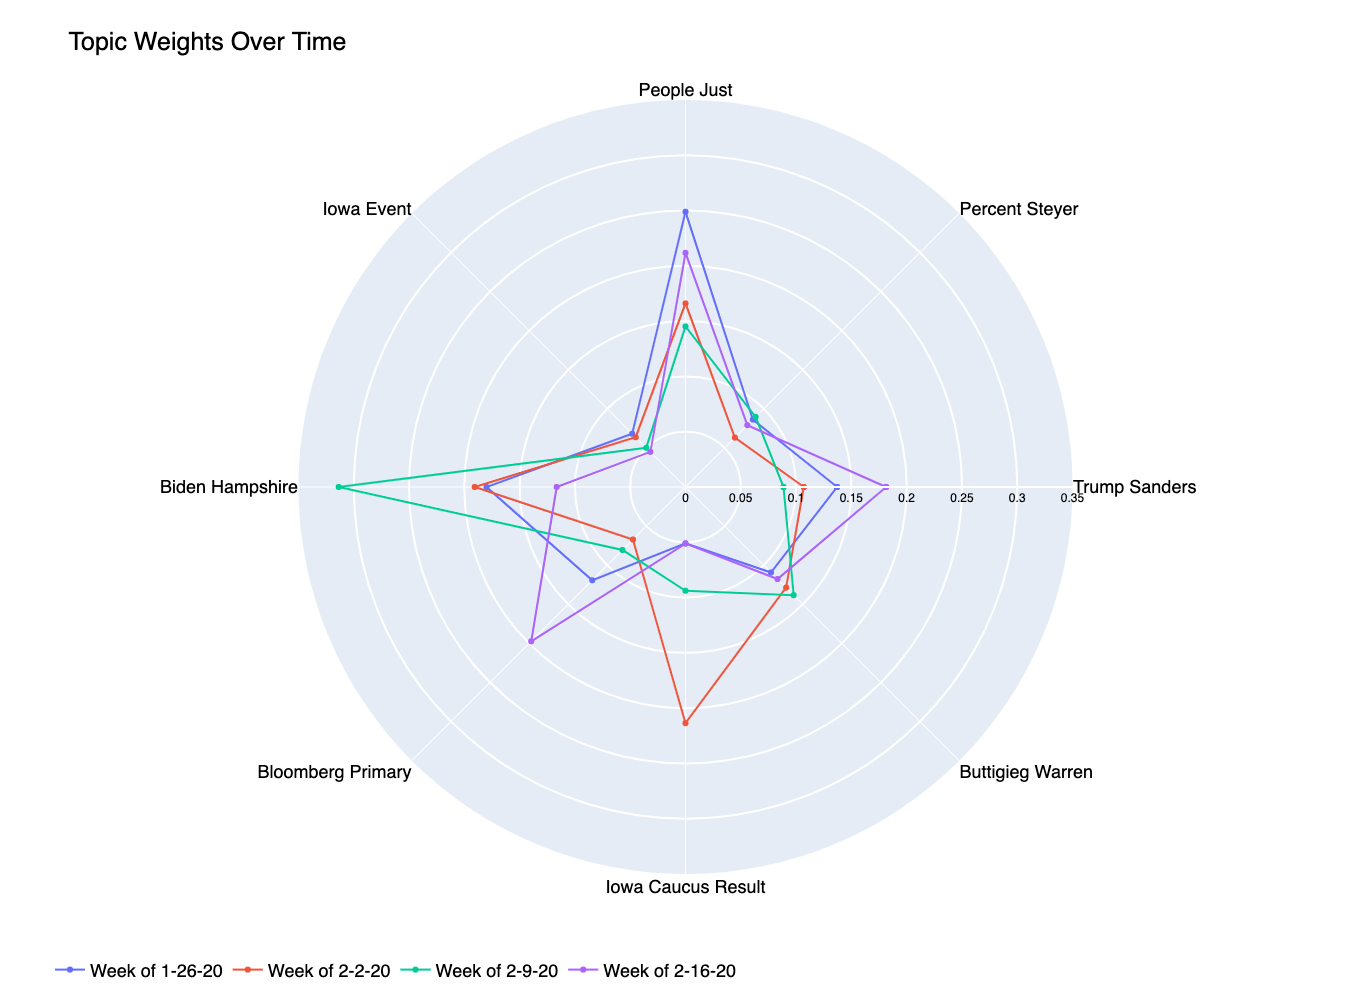

In [43]:
import plotly
import plotly.graph_objects as go

#categories = ['Bloomberg Debate','Voter Poll','Iowa Caucus Result',
#'Iowa Buttigieg', 'Buttigieg Klobuchar', 'Sanders Biden', 'Bloomberg Trump', 'Warren Woman']

categories = ['Trump Sanders','Percent Steyer','People Just',
              'Iowa Event', 'Biden Hampshire', 'Bloomberg Primary', 'Iowa Caucus Result', 'Buttigieg Warren']

base_week_description = 'Week of 2-2-20'

week_descriptions = ['Week of 1-26-20', 'Week of 2-9-20', 'Week of 2-16-20', 'Week of 2-23-20']

plot_cats = categories
plot_cats.append(categories[0])




fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor= 'rgba(0, 0, 0, 0)'
)




for i, week in enumerate(topic_other_weights[:1]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
#          fill='toself',
          name= week_descriptions[i]
    ))



    
plot_dat = topic_base_weights
plot_dat.append(plot_dat[0])
fig.add_trace(go.Scatterpolar(
      r=plot_dat,
      theta=plot_cats,
#      fill='toself',
      name= base_week_description
))

'''
'''
 
for i, week in enumerate(topic_other_weights[1:2]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
#          fill='toself',
          name= week_descriptions[i+1]
    ))


    
for i, week in enumerate(topic_other_weights[2:3]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
#          fill='toself',
          name= week_descriptions[i+2]
    ))
'''    
for i, week in enumerate(topic_other_weights[3:4]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
          fill='toself',
          name= week_descriptions[i+3]
    ))    

'''    
    
'''
layout = go.Layout(
    polar = dict(
        radialaxis_tickfont_size = 12,
        radialaxis = dict(
            visible = True,
            range = [0,350],

            ),
        ),
    font=dict(
    family="Helvetica, monospace",
    size=10,
    color="black"
    ))

'''    


layout = go.Layout(
    polar = dict(
      angularaxis = dict(
        linewidth = 3,
        showline=False,
        linecolor='black'
      ),
      radialaxis_tickfont_size = 12,
      radialaxis = dict(
        range = [0,0.35],
        showline = True,
        linewidth = 2,
        gridcolor = "white",
        gridwidth = 2
        
      )
    ),
    font=dict(
         family="Helvetica, monospace",
         size=10,
         color="black"
      )

)


fig.update_layout(layout)

    
layout = go.Layout(
    title="Topic Weights Over Time",
    
    font=dict(
        family="Helvetica, monospace",
        size=18,
        color="Black"
    ),

    showlegend=True,
    legend_orientation='h'
)

fig.update_layout(layout)
fig.show()

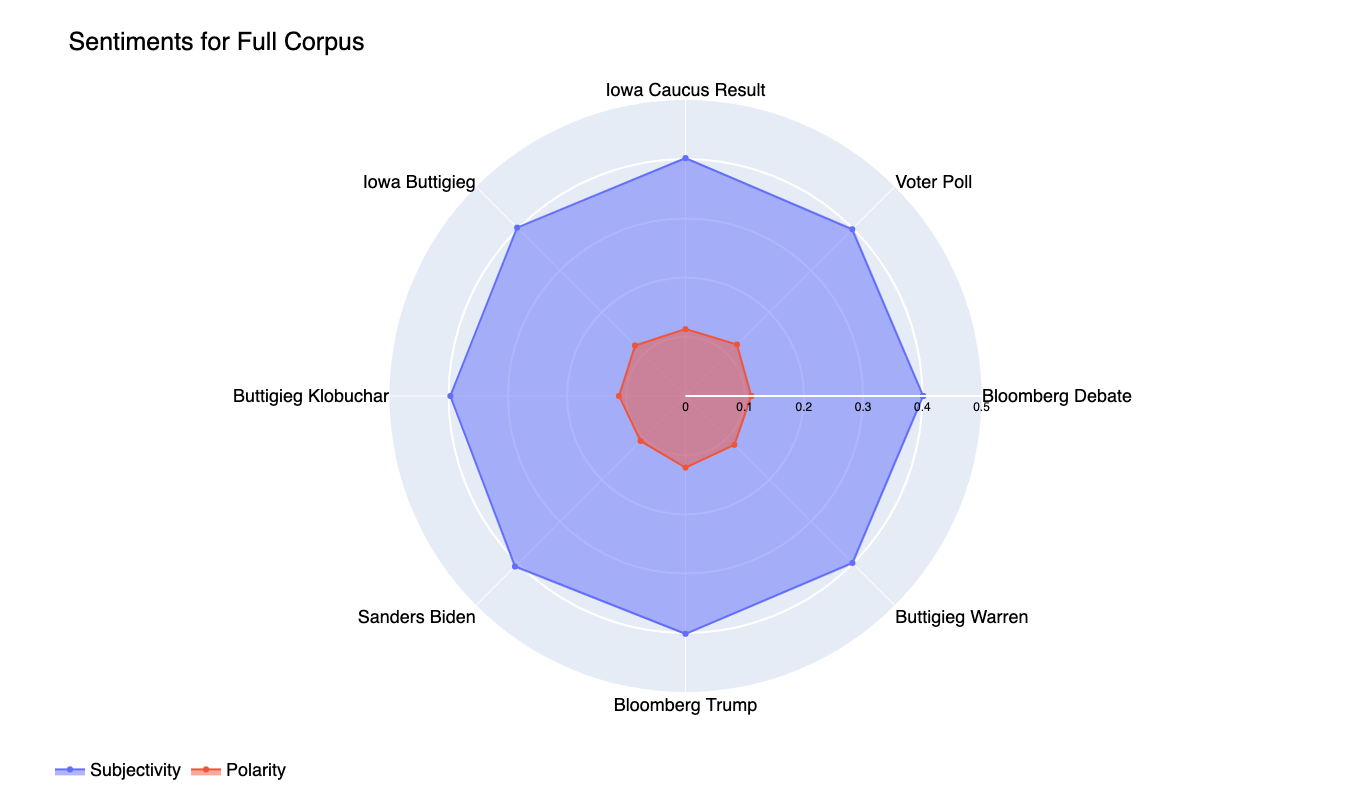

In [111]:
import plotly
import plotly.graph_objects as go

categories = ['Bloomberg Debate','Voter Poll','Iowa Caucus Result',
              'Iowa Buttigieg', 'Buttigieg Klobuchar', 'Sanders Biden', 'Bloomberg Trump', 'Buttigieg Warren']

base_week_description = 'Full Corpus'

week_descriptions = ['Week of 1-26-20', 'Week of 2-9-20', 'Week of 2-16-20', 'Week of 2-23-20']

plot_cats = categories
plot_cats.append(categories[0])




fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor= 'rgba(0, 0, 0, 0)'
)


'''

for i, week in enumerate(topic_other_weights[:1]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
#          fill='toself',
          name= week_descriptions[i]
    ))
'''


    
plot_dat = list(base_subjectivity)
plot_dat.append(plot_dat[0])
fig.add_trace(go.Scatterpolar(
      r=plot_dat,
      theta=plot_cats,
      fill='toself',
      name= 'Subjectivity'
))

plot_dat = list(base_polarity)
plot_dat.append(plot_dat[0])
fig.add_trace(go.Scatterpolar(
      r=plot_dat,
      theta=plot_cats,
      fill='toself',
      name= 'Polarity'
))

''' 
for i, week in enumerate(topic_other_weights[1:2]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
#          fill='toself',
          name= week_descriptions[i+1]
    ))


    
for i, week in enumerate(topic_other_weights[2:3]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
#          fill='toself',
          name= week_descriptions[i+2]
    ))
    
for i, week in enumerate(topic_other_weights[3:4]) :
    plot_dat = week
    plot_dat.append(plot_dat[0])
    fig.add_trace(go.Scatterpolar(
          r=plot_dat,
          theta=categories,
          fill='toself',
          name= week_descriptions[i+3]
    ))    

'''    
    
'''
layout = go.Layout(
    polar = dict(
        radialaxis_tickfont_size = 12,
        radialaxis = dict(
            visible = True,
            range = [0,350],

            ),
        ),
    font=dict(
    family="Helvetica, monospace",
    size=10,
    color="black"
    ))

'''    


layout = go.Layout(
    polar = dict(
      angularaxis = dict(
        linewidth = 3,
        showline=False,
        linecolor='black'
      ),
      radialaxis_tickfont_size = 12,
      radialaxis = dict(
        range = [0,0.5],
        showline = True,
        linewidth = 2,
        gridcolor = "white",
        gridwidth = 2
        
      )
    ),
    font=dict(
         family="Helvetica, monospace",
         size=10,
         color="black"
      )

)


fig.update_layout(layout)

    
layout = go.Layout(
    title="Sentiments for Full Corpus",
    
    font=dict(
        family="Helvetica, monospace",
        size=18,
        color="Black"
    ),

    showlegend=True,
    legend_orientation='h'
)

fig.update_layout(layout)
fig.show()

In [29]:
plot_dat

array([ 81.71047255,  51.38030811, 148.3873214 ,  40.63697206,
       107.24878611,  71.0826246 ,  30.397209  ,  65.15630617])